In [1]:
import os
from datetime import datetime
import numpy as np
import glob

import PIL

import matplotlib.pyplot as plt

In [2]:
SAT_IMAGERY_PATH = '/media/jack/Backup/data_not_stored_on_laptop/eumetsat/dexter/jpegs'

In [3]:
def get_directory_for_datetime(sat_imagery_path: str, dt: datetime) -> str:
    """
    Args:
        sat_imagery_path:
        dt: the datetime for the requested image.  Will return
            the directory which is within 5 minutes of the requested image.
    Returns:
        Directory string
        
    Raises:
        FileNotFoundError
    """
    hour_path = dt.strftime("%Y/%m/%d/%H")
    hour_path = os.path.join(SAT_IMAGERY_PATH, hour_path)
    
    # Get a list of subdirectories containing minutes
    _, minute_dirs, _ = next(os.walk(hour_path))
    minutes_with_images = np.array(minute_dirs, dtype=int)
    
    # Quantize dt.minute to 5-minute intervals
    minute_lower_bound = (dt.minute // 5) * 5
    minute_upper_bound = minute_lower_bound + 5
    
    # Find matching directory for the minutes
    selection_condition = (
        (minute_lower_bound <= minutes_with_images) & 
        (minutes_with_images < minute_upper_bound))
    idx = np.flatnonzero(selection_condition)
    
    # Sanity check
    if idx.size == 0:
        raise FileNotFoundError(2, 'No minute directory for datetime {} under "{}"'.format(dt, hour_path))
    elif idx.size > 1:
        raise RuntimeError(
            'Found > 1 directories with images for datetime {}.'
            '  Base dir = "{}".  Subdirs found = {}'
            .format(dt, hour_path, minute_dirs))
        
    selected_minute_dir = minutes_with_images[idx[0]]
    selected_minute_dir = '{:02d}'.format(selected_minute_dir)
    selected_minute_dir = os.path.join(hour_path, selected_minute_dir)
    
    return selected_minute_dir

dt = datetime(year=2017, month=7, day=1, hour=12, minute=0)
image_path = get_directory_for_datetime(SAT_IMAGERY_PATH, dt)
image_path

'/media/jack/Backup/data_not_stored_on_laptop/eumetsat/dexter/jpegs/2017/07/01/12/04'

In [4]:
def get_image_filename_for_datetime(
    sat_imagery_path: str, 
    dt: datetime,
    pattern: str = 'HRV*.jpg'
    ) -> str:
    
    image_path = get_directory_for_datetime(sat_imagery_path, dt)
    files = glob.glob(os.path.join(image_path, pattern))
    error_str = 'file matching "{}" in "{}" for datetime {}.'.format(pattern, image_path, dt)
    if len(files) == 0:
        raise FileNotFoundError(2, 'No ' + error_str)
    if len(files) > 1:
        raise RuntimeError('Found > 1 ' + error_str + '  Expected only one match.')
    image_filename = files[0]
    return image_filename

image_filename = get_image_filename_for_datetime(SAT_IMAGERY_PATH, dt)
image_filename

'/media/jack/Backup/data_not_stored_on_laptop/eumetsat/dexter/jpegs/2017/07/01/12/04/HRV_MSG2-SEVI-MSG15-0100-NA-20170701120417.jpg'

In [5]:
image_jack = PIL.Image.open("/home/jack/data/EUMETSAT/testing/one-hour/format-4-jpeg/extracted/jpeg/HRV_MSG3-SEVI-MSG15-0100-NA-20190423080416.jpg")

/home/jack/miniconda3/envs/sat_image_processing/lib/python3.7/site-packages/PIL/Image.py:2735: DecompressionBombWarning: Image size (124010496 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


In [6]:
image_dexter = np.array(PIL.Image.open(image_filename))

In [7]:
def crop(img):
    img_middle = (img.shape[1] / 2) + 18
    hrv_image_width = 5568

    img_start_col = int(round(
        img_middle - (hrv_image_width / 2)
    ))

    img_end_col = int(round(
        img_middle + (hrv_image_width / 2)
    ))

    return img[:4176, img_start_col:img_end_col].copy()

image_jack = crop(np.array(image_jack))

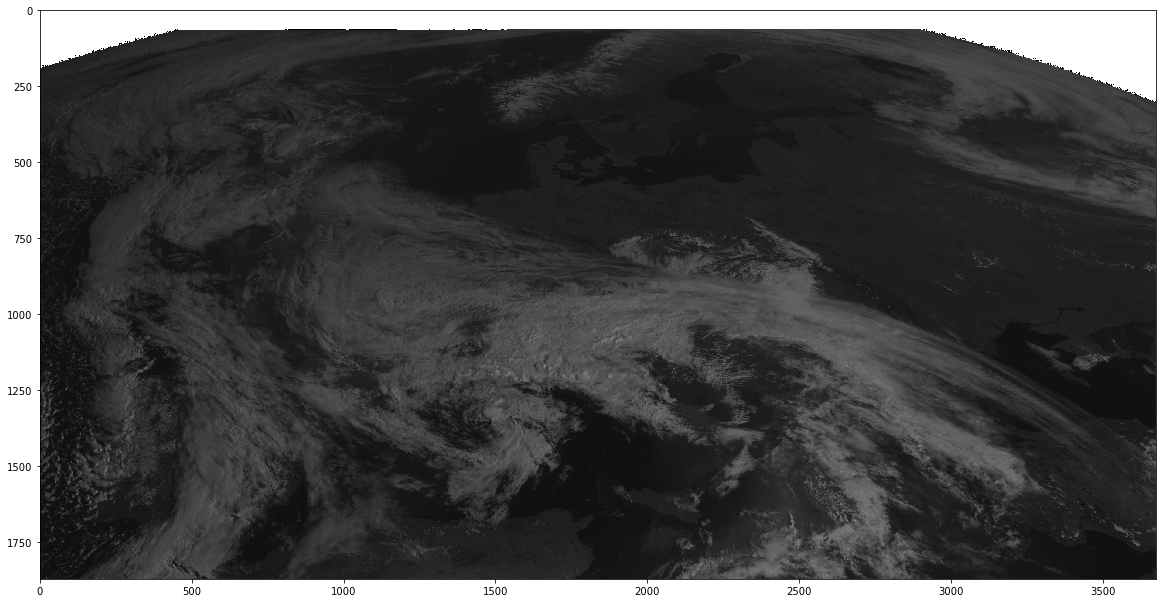

In [8]:
left = int((image_jack.shape[1] - image_dexter.shape[1]) / 2)
left += 140
right = left+image_dexter.shape[1]
top = 235
bottom = top+image_dexter.shape[0]

fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(
    -image_jack[
        top:bottom, 
        left:right],
    cmap='binary'
);

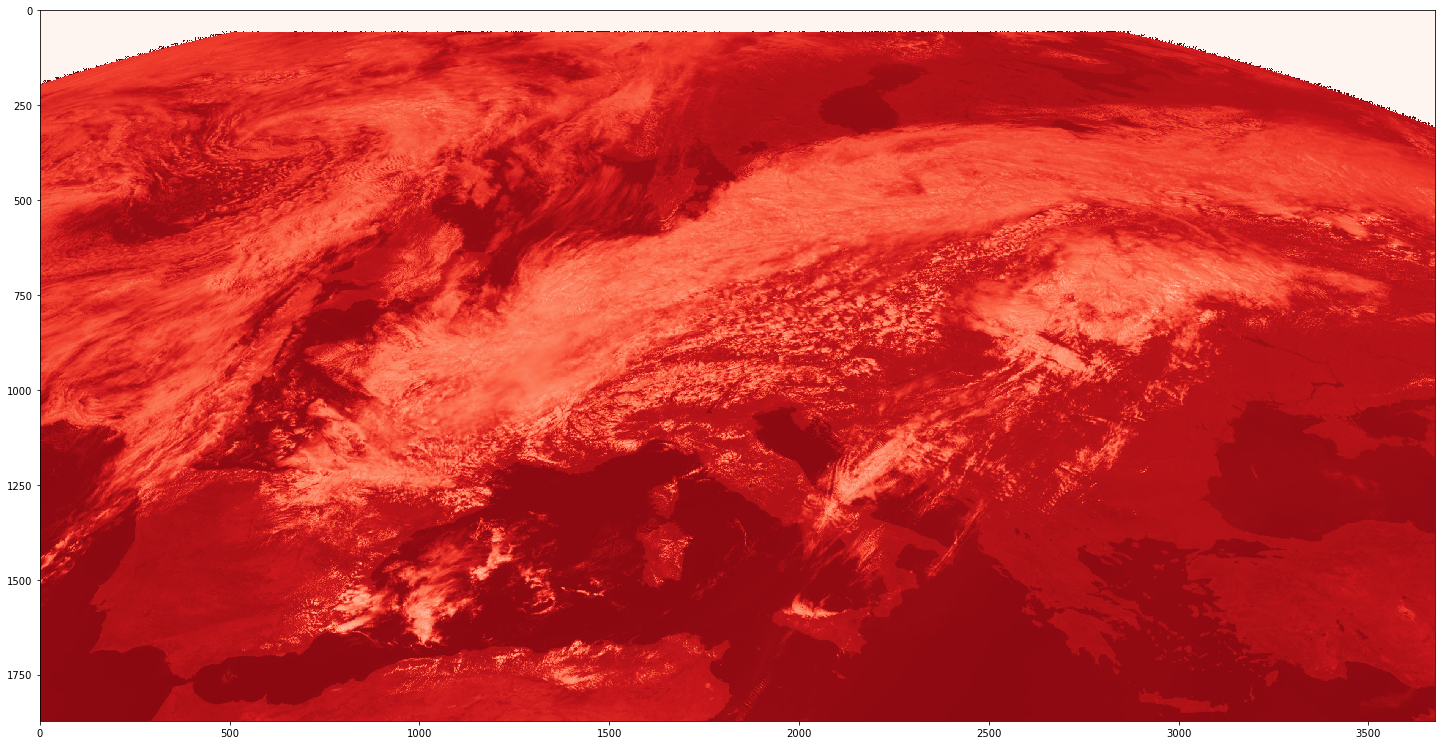

In [9]:
fig, ax = plt.subplots(figsize=(25, 25))
ax.imshow(-image_dexter, cmap='Reds', alpha=1)

#ax.imshow(
#    #image_dexter- 
#    -image_jack[
#        top:bottom, 
#        left:right],
#    alpha=0.5,
#    cmap='Blues'
#)

In [10]:
left, right, top, bottom

(1086, 4761, 235, 2107)

In [11]:
dexter_padded = np.empty(image_jack.shape, dtype=np.float32)
dexter_padded[:, :] = np.nan
dexter_padded[top:bottom, left:right] = image_dexter

# mask NaNs
dexter_padded = np.ma.fix_invalid(dexter_padded)

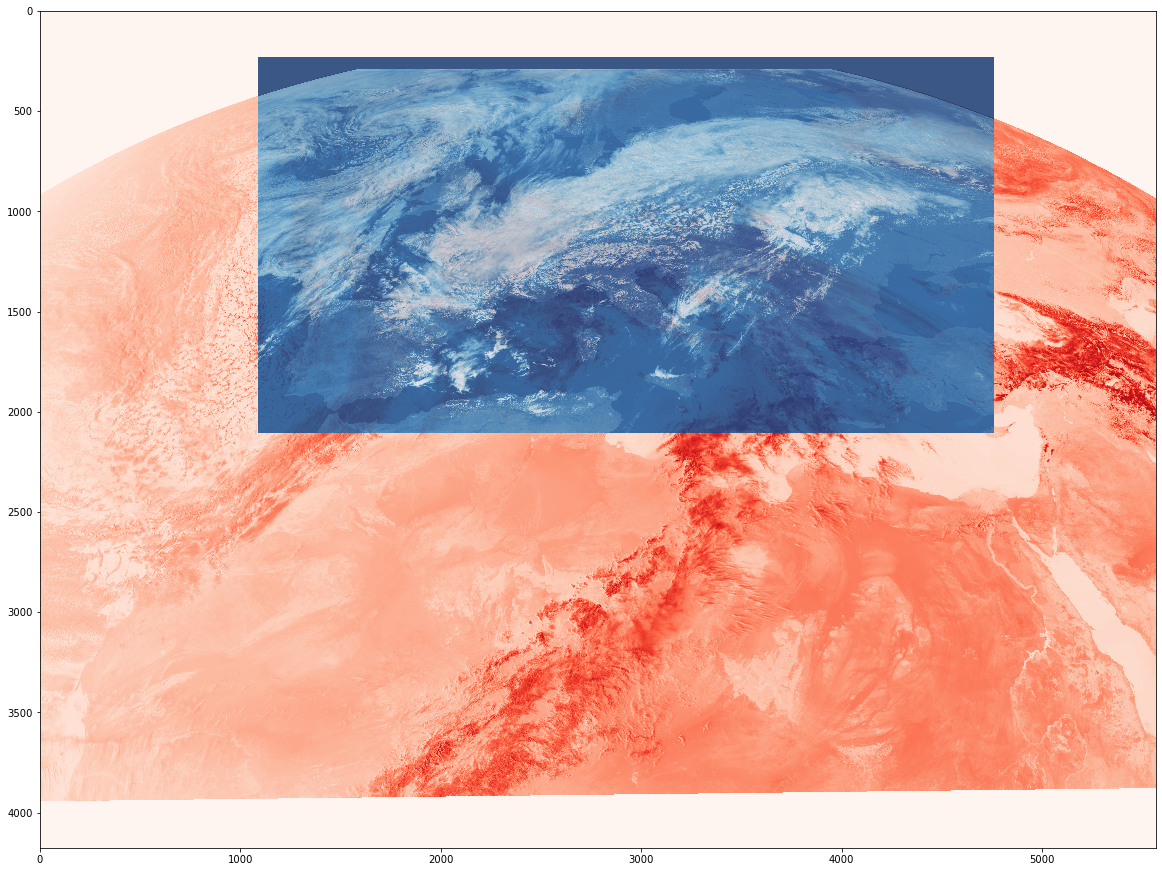

In [12]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(image_jack, cmap='Reds')
ax.imshow(-dexter_padded, alpha=0.8, cmap='Blues');

In [13]:
import pandas as pd

In [14]:
proportions = pd.Series({
    'left': left / image_jack.shape[1],
    'right': right / image_jack.shape[1],
    'bottom': top / image_jack.shape[0],
    'top': bottom / image_jack.shape[0]
})
proportions

left      0.195043
right     0.855065
bottom    0.056274
top       0.504550
dtype: float64

In [15]:
EXTENT_ORDER = ['right', 'top', 'left', 'bottom']

area_extent_seviri_rss_s = pd.Series({
        'right': 2799876.1893, # lower left x   # upper right x
        'top': 5571248.5489, # lower left y   # upper right y
        'left': -2768872.0236, # upper right x # lower left x
        'bottom': 1394687.3892
})  # upper right y # lower left y

area_extent_seviri_rss_s['height'] = area_extent_seviri_rss_s['top'] - area_extent_seviri_rss_s['bottom']
area_extent_seviri_rss_s['width'] = area_extent_seviri_rss_s['right'] - area_extent_seviri_rss_s['left']

area_extent_seviri_rss_s

right     2.799876e+06
top       5.571249e+06
left     -2.768872e+06
bottom    1.394687e+06
height    4.176561e+06
width     5.568748e+06
dtype: float64

In [16]:
dexter_extent = pd.Series({
    'left': (area_extent_seviri_rss_s['width'] * proportions['left']) + area_extent_seviri_rss_s['left'],
    'right': (area_extent_seviri_rss_s['width'] * proportions['right']) + area_extent_seviri_rss_s['left'],
    'top': (area_extent_seviri_rss_s['height'] * proportions['top']) + area_extent_seviri_rss_s['bottom'],
    'bottom': (area_extent_seviri_rss_s['height'] * proportions['bottom']) + area_extent_seviri_rss_s['bottom'],
})

dexter_extent = dexter_extent[EXTENT_ORDER]
dexter_extent

right     1.992768e+06
top       3.501971e+06
left     -1.682726e+06
bottom    1.629719e+06
dtype: float64

In [17]:
area_extent_seviri_rss = area_extent_seviri_rss_s[EXTENT_ORDER].to_list()
area_extent_seviri_rss

[2799876.1893, 5571248.5489, -2768872.0236, 1394687.3892]

In [18]:
dexter_extent

right     1.992768e+06
top       3.501971e+06
left     -1.682726e+06
bottom    1.629719e+06
dtype: float64

In [19]:
area_extent_seviri_rss_s[EXTENT_ORDER]

right     2.799876e+06
top       5.571249e+06
left     -2.768872e+06
bottom    1.394687e+06
dtype: float64

In [20]:
image = dexter_padded

In [21]:
import pyresample
from pyresample import geo_filter, geometry, load_area

seviri = geometry.AreaDefinition(
    area_id='seviri',
    description='SEVIRI RSS',
    proj_id='seviri',   
    projection={
         'proj': 'geos',
         'lon_0': 9.5,
         'a': 6378169.00,
         'b': 6356583.800000001,
         'h': 35785831.00,
         'units': 'm'},
    width=image.shape[1],
    height=image.shape[0],
    area_extent=area_extent_seviri_rss
)

seviri

Area ID: seviri
Description: SEVIRI RSS
Projection ID: seviri
Projection: {'a': '6378169', 'b': '6356583.8', 'h': '35785831', 'lon_0': '9.5', 'no_defs': 'None', 'proj': 'geos', 'type': 'crs', 'units': 'm', 'x_0': '0', 'y_0': '0'}
Number of columns: 5568
Number of rows: 4176
Area extent: (2799876.1893, 5571248.5489, -2768872.0236, 1394687.3892)

In [22]:
image.shape

(4176, 5568)

In [23]:
europe = geometry.AreaDefinition(
    area_id='areaD',
    description='Europe (3km, HRV, VTC)',
    proj_id='areaD',
    projection={
             #'a': '6378144.0',
             #'b': '6356759.0',
             'lat_0': '90.0',
             'lat_ts': '60.00',
             'lon_0': '0.00',
             'ellps': 'WGS84',
             'proj': 'stere'},
    width=image.shape[1], 
    height=image.shape[0],
    area_extent=[-3780000.0, -7644000.0, 3900000.0, -1500000.0])

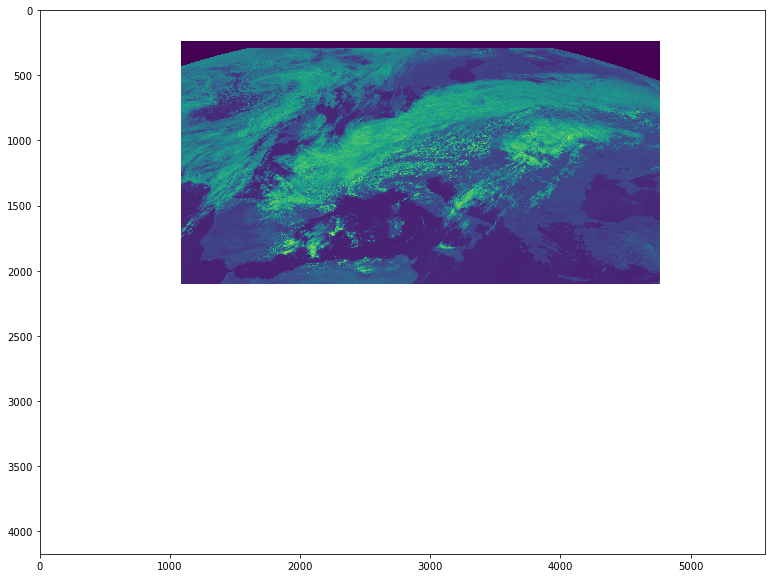

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(image);

In [25]:
%%time

# TODO: Use ImageContainerNearest for best-quality conversions!
seviri_image = pyresample.image.ImageContainerQuick(
    image[::-1, ::-1], 
    seviri, 
    fill_value=None,  # If None, return masked array.  Doesn't appear to speed it up though!
    nprocs=2
)
resampled = seviri_image.resample(europe)

CPU times: user 2.63 s, sys: 548 ms, total: 3.18 s
Wall time: 25.5 s


In [26]:
resampled.shape

(4176, 5568)

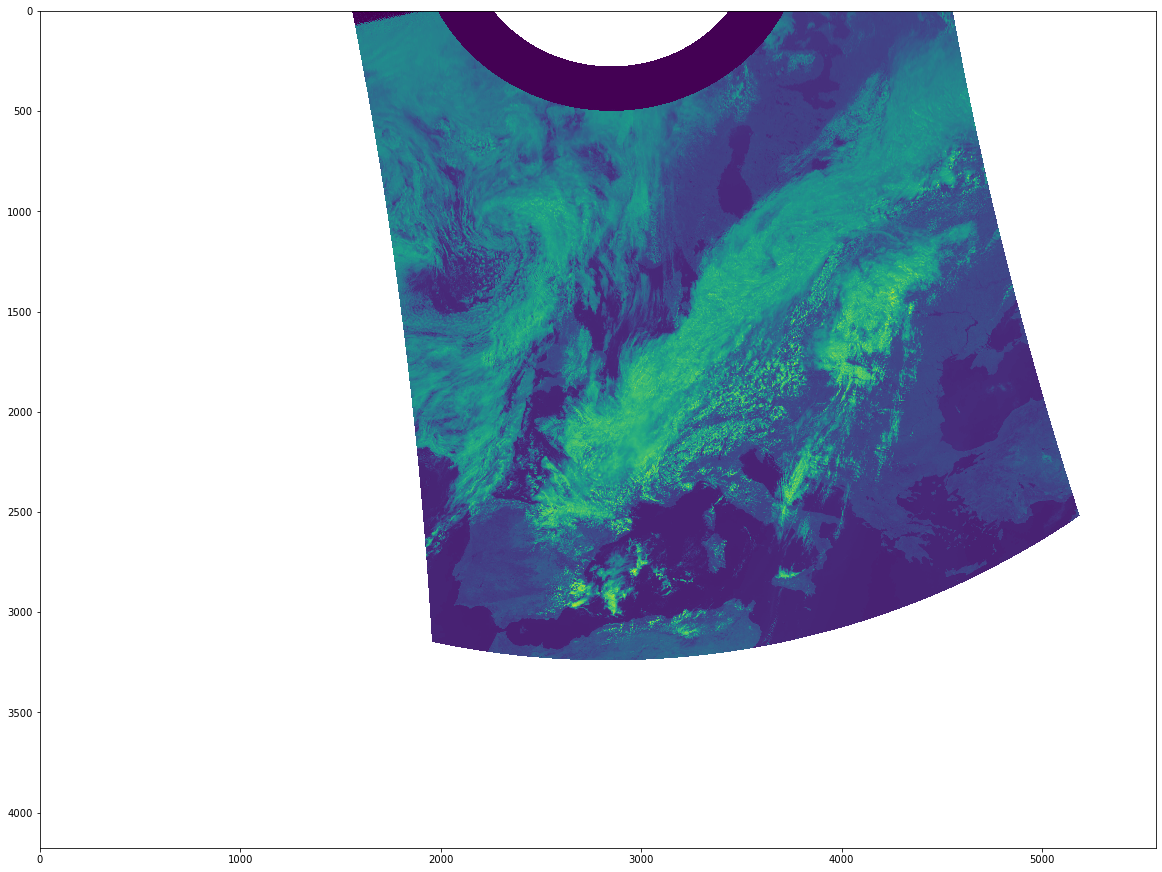

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(resampled.image_data);

In [28]:
# from pyresample import save_quicklook

# Code from https://pyresample.readthedocs.io/en/latest/plot.html#the-globe-projections
# save_quicklook('projection.png', europe, resampled.image_data)

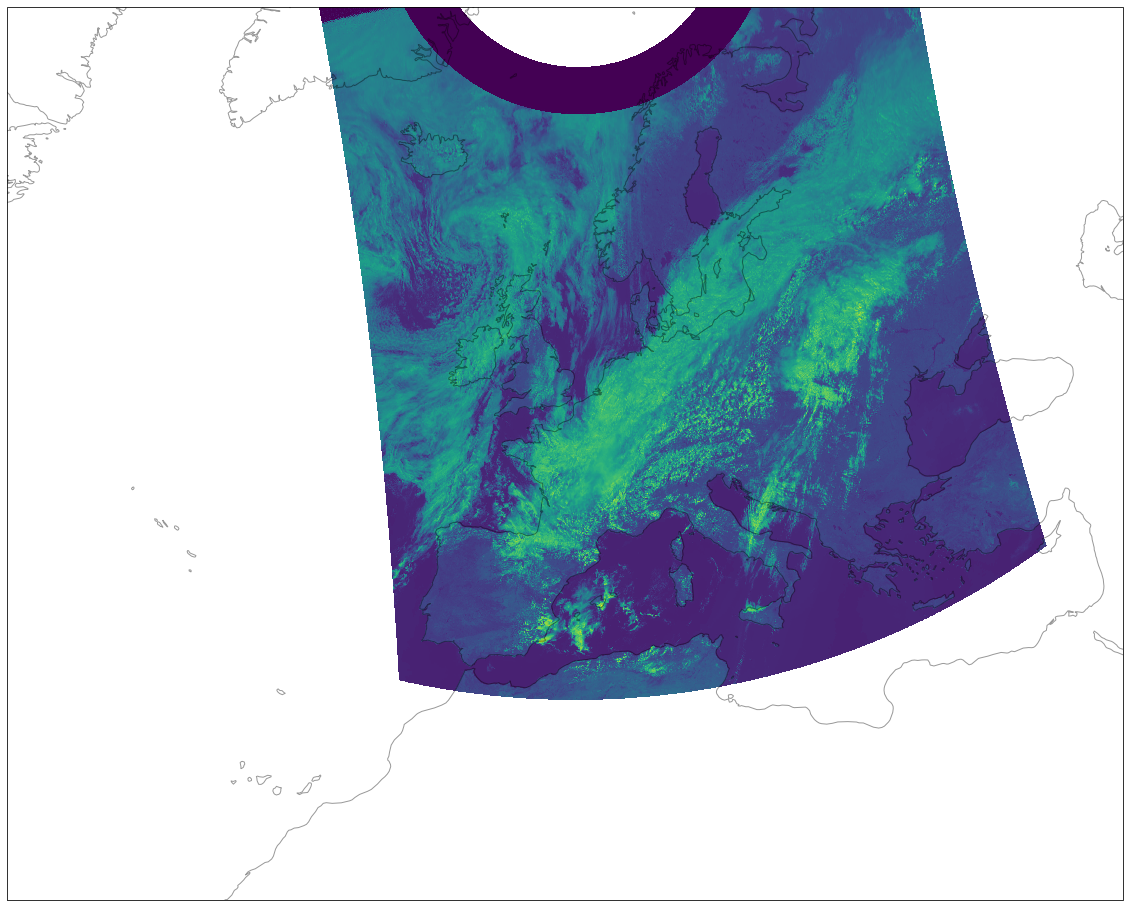

In [29]:
# Attempt to overlay coastlines
# See https://pyresample.readthedocs.io/en/latest/plot.html#getting-a-cartopy-crs
crs = europe.to_cartopy_crs()
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection=crs)
ax.coastlines(resolution='50m', alpha=0.4)
# ax.set_global()
plt.imshow(
    resampled.image_data, 
    extent=crs.bounds,
    #transform=crs,   # Don't need to transform if image data is already in correct projection, I think.
    #origin='upper'
);